In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import *
import wandb
%matplotlib inline

In [9]:
class model_encoder(nn.Module):
    def __init__(self):
        super(model_encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 5, stride=1, padding=2),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 8, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 1, 3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            
        )
        self.fc1 = nn.Linear(16, 8)
        self.fc2 = nn.Linear(8, 16)
        self.decoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 16, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(16, 8, 5, stride=1, padding=2),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(8, 4, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(4, 1, 3, stride=1, padding=1),
        )
        
    def forward(self, x):
        x=self.encoder(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = x.reshape(x.size(0), 1,4, 4)
        x=self.decoder(x)
        #print(x.shape)
        return x

In [3]:
model=model_encoder()

In [4]:
model(test_dataset[0][0].unsqueeze(1))

NameError: name 'test_dataset' is not defined

In [5]:
batch_size = 256
board=np.load('board.npy')/1000
board=torch.tensor(board, dtype=torch.float32)
board=torch.reshape(board, (board.shape[0],1, 32,32))
board=TensorDataset(board)
train_dataset, test_dataset = random_split(board, [450000, 240288])
dataset=DataLoader(board,  batch_size=batch_size, shuffle=True, pin_memory=True)

In [10]:
num_epochs = 6
learning_rate = 1.2e-3
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=model_encoder().to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
loss_fn=torch.nn.BCEWithLogitsLoss()
model.train()

model_encoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=16, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=16, bias=True)
  (decoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Upsample(scale_factor=2, mode=nearest)
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): Upsample(scale_fact

In [11]:
j=0
wandb.init('halite')
#sched=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1757,1e-2,-1)
for i in range(num_epochs):
    for data in dataset:
        data=data[0].to(device)
        res=model(data)
        optimizer.zero_grad()
        loss=loss_fn(res,data)
        loss.backward()
        optimizer.step()
        #sched.step()
        wandb.log({"Loss": loss})
        j+=1

W&B Run: https://app.wandb.ai/arb426/halite/runs/vrunpj0r
Call `%%wandb` in the cell containing your training loop to display live results.


/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Resuming run: https://app.wandb.ai/arb426/halite/runs/vrunpj0r


/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


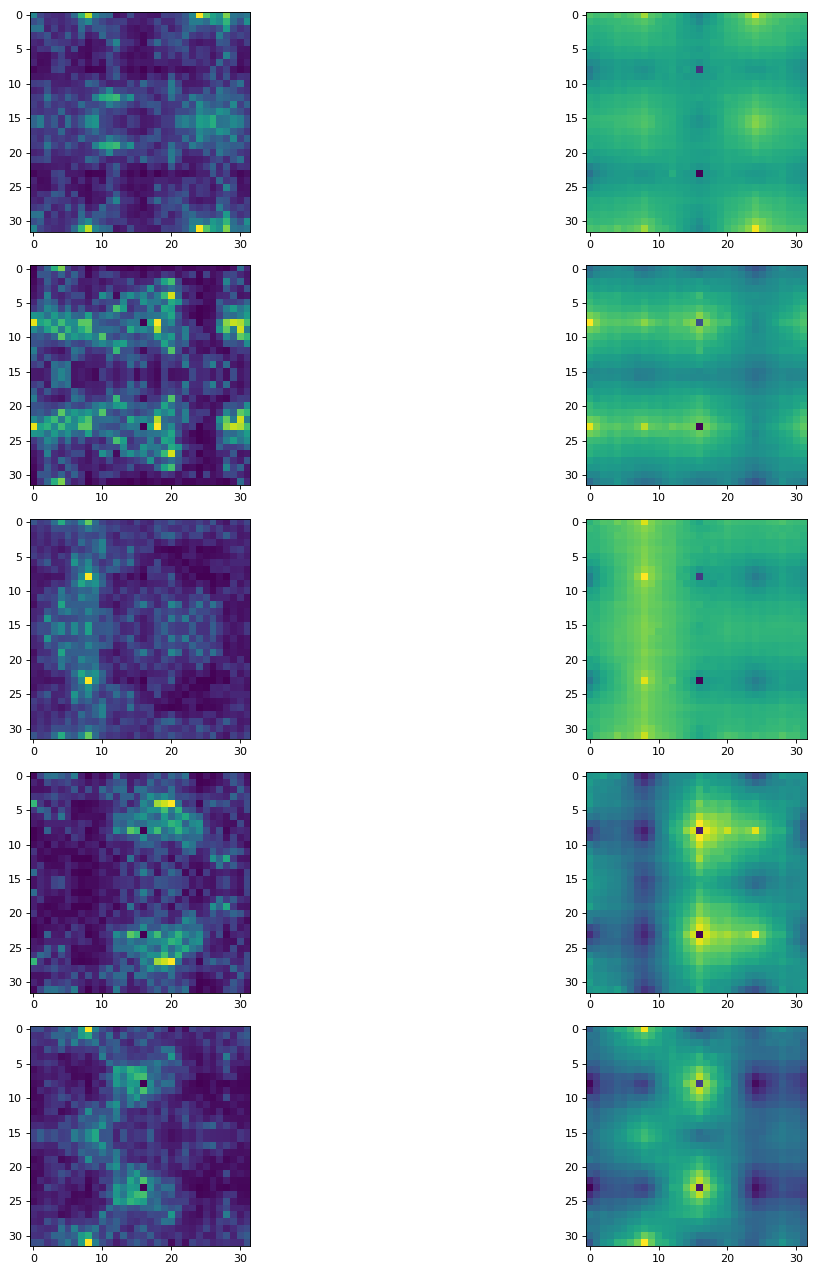

In [14]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
for i in range(5):
    j=np.random.randint(0,40288)
    img=model(test_dataset[j][0].unsqueeze(1).to(device))
    plt.subplot(5,2,2*i+1)
    plt.imshow(test_dataset[j][0].squeeze(0).cpu().numpy())
    plt.subplot(5,2,2*i+2)
    plt.imshow(torch.reshape(img,(32,32)).detach().cpu().numpy())
plt.tight_layout()

In [ ]:
def learning_rate_finder():
    loss_res=[]
    lr_ls=[]
    lr=1e-5
    j=0
    for g in optimizer.param_groups:
            g['lr'] = lr
    for data in dataset:
        data=data[0].to(device)
        res=model(data)
        optimizer.zero_grad()
        loss=loss_fn(res,data)
        loss.backward()
        optimizer.step()
        loss_res.append(loss.cpu().detach().numpy())
        lr_ls.append(lr)
        lr= 1e-5 * (1.011 ** j)
        for g in optimizer.param_groups:
            g['lr'] = lr
        j+=1
        if loss>np.min(loss_res)*4:
            return lr_ls,loss_res

In [ ]:
lr_ls,res=learning_rate_finder()
plt.semilogx(lr_ls[:-2],res[:-2])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate Finder')